In [1]:
import os
from collections import Counter
import nltk
import gensim  #for topic modelling
from bs4 import BeautifulSoup #for extracting text 
import nltk # for text preprocessing
import re 
import pandas as pd
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.decomposition import NMF
import matplotlib 
import matplotlib.pyplot as plt
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.rcParams['figure.figsize'] = (20,10)

import warnings
warnings.filterwarnings('ignore')

### read data

In [2]:
path = './inaugural_speeches/'
files = [path + fname for fname in os.listdir(path)]
files[0]

'./inaugural_speeches/37_roosevelt_franklin_1933.txt'

In [3]:
data = []
for fname in files:
    with open(fname, 'r') as f:
        lines = ' '.join(f.readlines())
        data.append(lines)

In [4]:
stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen', u'law', u'right', u'union',u'power', u'year', u'world', u'interest', u'purpose', u'justice',u'principle', u'it', u'time', u'question', u'executive', u'war',u'peace', u'life', u'institution', u'condition', u'effort', u'land',u'faith', u'place', u'office', u'today', u'thing', u'opinion',u'home', u'action', u'god', u'cause', u'century', u'strength', u'danger', u'revenue',u'subject',u'republic', 'ha', 'man', 'men', 'day', 'hope', 'u'])
#stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen'])

###  remove stopwords, punctuation, pos tag

In [5]:
stop = set(stopwords.words('english'))
stop.update(stoplist)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    doc_filter = " ".join([word for word, pos in nltk.pos_tag(normalized.lower().split()) if pos=='NN' ])
    stop_free = [i for i in doc_filter.split() if i not in stop]

    doc_count = pd.Series(stop_free).value_counts()
    doc_count = set(doc_count[doc_count==1].index.values)
    new_words = ' '.join([w for w in stop_free if w not in doc_count])
    
    return new_words

In [6]:
doc_clean = [clean(doc).split() for doc in data]

### pos distribution

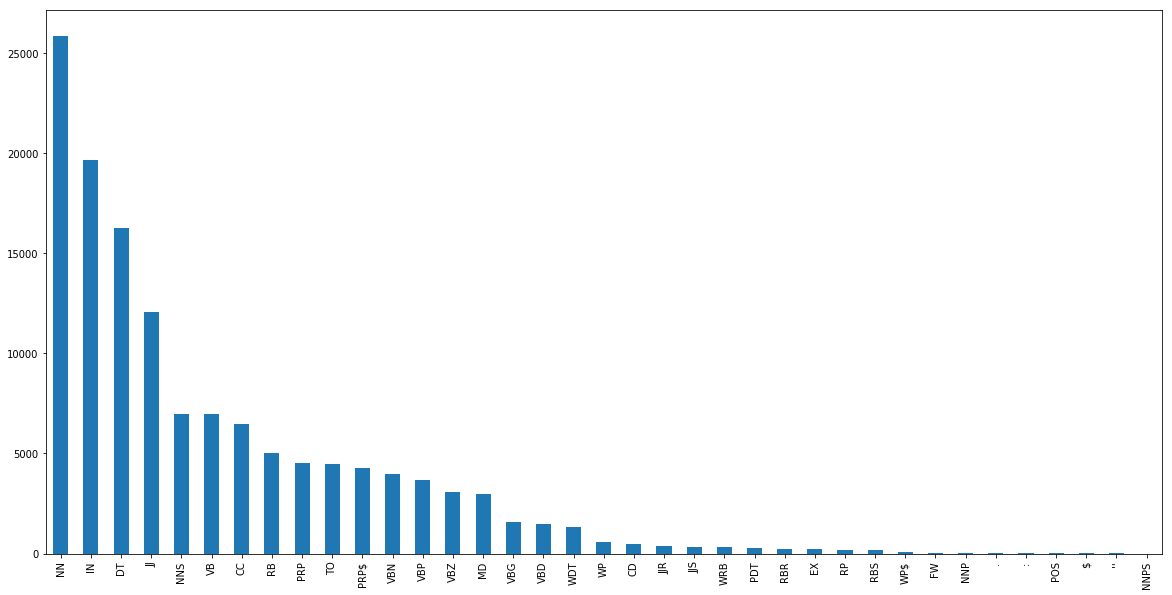

In [7]:
pos = [pos for doc in data for word, pos in nltk.pos_tag(doc.lower().split())]
pos = pd.Series(pos)
pos.value_counts().head(50).plot.bar()

### word distribution

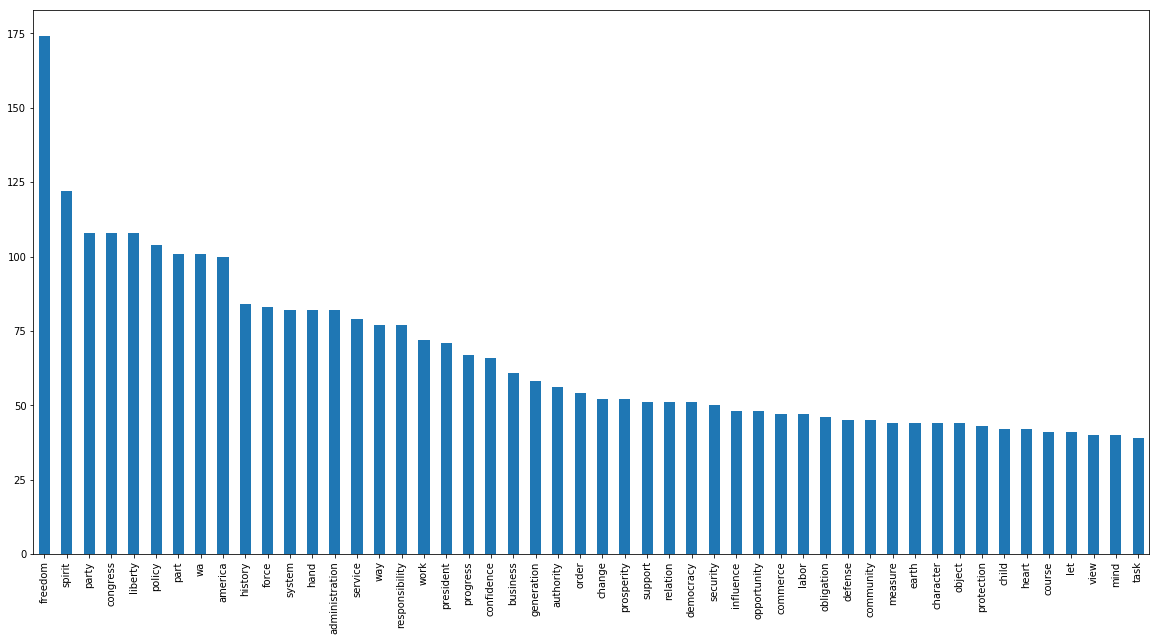

In [8]:
all_tokens = [x for y in doc_clean for x in y]
all_tokens = pd.Series(all_tokens)
all_tokens.value_counts().head(50).plot.bar()

In [9]:
all_tokens.value_counts().head(50).index.values

array(['freedom', 'spirit', 'party', 'congress', 'liberty', 'policy',
       'part', 'wa', 'america', 'history', 'force', 'system', 'hand',
       'administration', 'service', 'way', 'responsibility', 'work',
       'president', 'progress', 'confidence', 'business', 'generation',
       'authority', 'order', 'change', 'prosperity', 'support', 'relation',
       'democracy', 'security', 'influence', 'opportunity', 'commerce',
       'labor', 'obligation', 'defense', 'community', 'measure', 'earth',
       'character', 'object', 'protection', 'child', 'heart', 'course',
       'let', 'view', 'mind', 'task'], dtype=object)

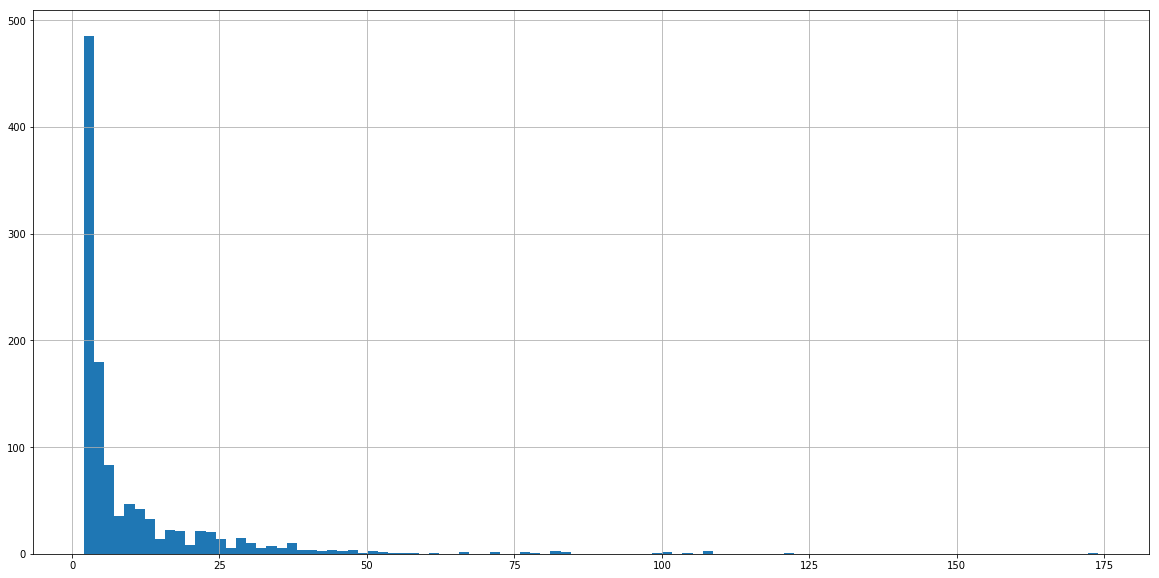

In [10]:
all_tokens.value_counts().hist(bins=100)

### plot theme of some transcripts

(-0.5, 399.5, 199.5, -0.5)

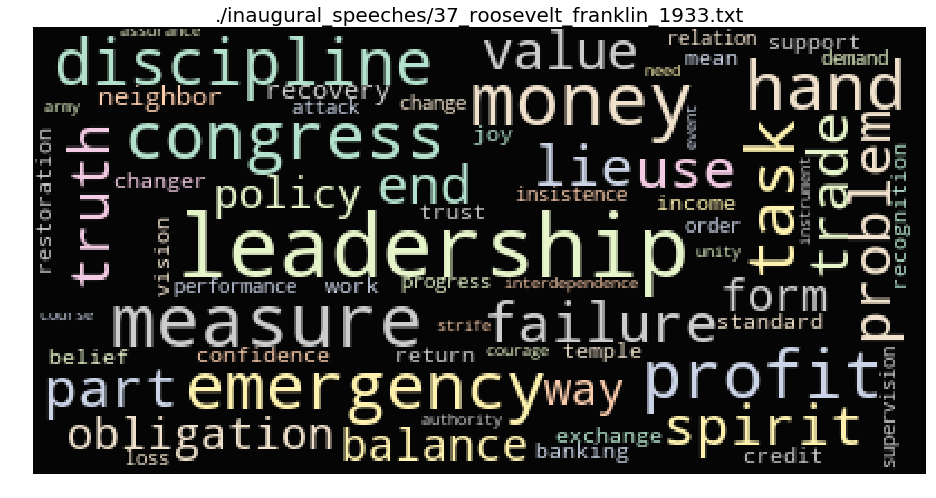

In [11]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[0]))
plt.title(files[0], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

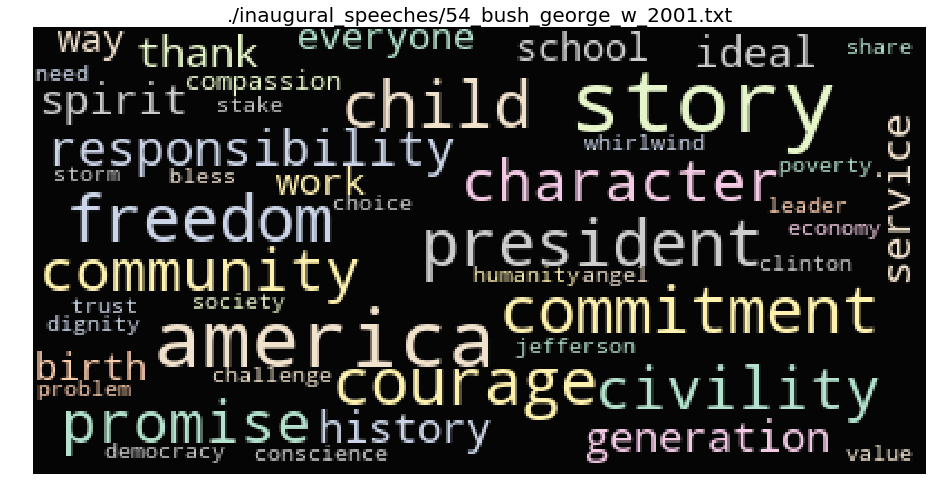

In [12]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[1]))
plt.title(files[1], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

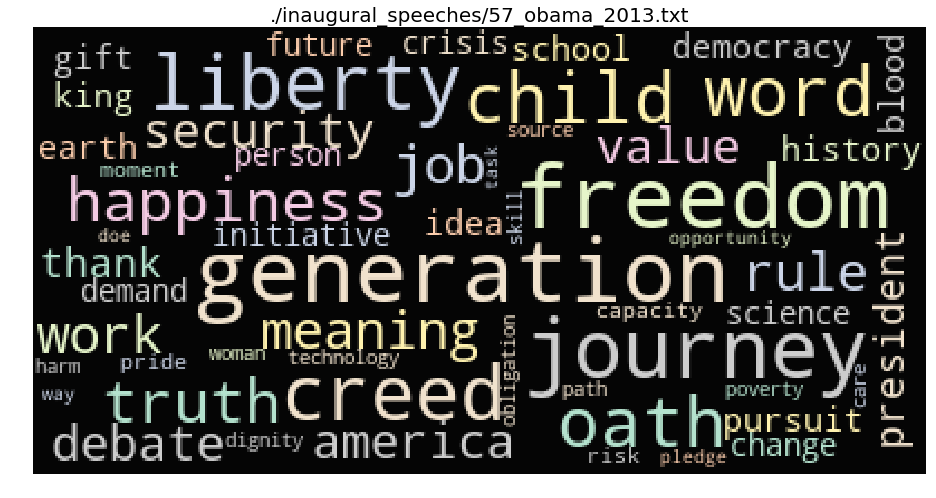

In [13]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[23]))
plt.title(files[23], fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

In [14]:
word_counts = pd.Series(np.concatenate(doc_clean)).value_counts()
singular_words = set(word_counts[pd.Series(np.concatenate(doc_clean)).value_counts() <= 2].index)

In [15]:
len(singular_words)

407

In [16]:
doc_stemmed = [[word for word in title if word not in singular_words] for title in doc_clean]

In [17]:
non_empty_indices = [i for i in range(len(doc_stemmed)) if len(doc_stemmed[i]) > 0]
doc_stemmed = np.asarray(doc_stemmed)[non_empty_indices]

In [18]:
dictionary = gensim.corpora.Dictionary(doc_stemmed)

In [19]:
corpus = [dictionary.doc2bow(text) for text in doc_stemmed]


In [20]:
model =  gensim.models.ldamodel.LdaModel
ldamodel = model(corpus, num_topics=20, id2word = dictionary, passes=200)

In [21]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
18     10.483141        1       1  0.106648  0.145658
17      9.752037        1       2  0.110196 -0.130905
19      8.455792        1       3 -0.030539  0.127013
5       7.559384        1       4  0.000728  0.005163
16      7.082697        1       5  0.110214 -0.112847
3       6.330434        1       6 -0.083354  0.000322
4       6.057763        1       7 -0.044651  0.125432
7       6.009970        1       8 -0.325999 -0.004469
9       5.875326        1       9  0.057462  0.003393
2       5.846838        1      10 -0.140470 -0.053629
6       4.554871        1      11  0.141170  0.134831
10      4.444788        1      12  0.089003 -0.119234
13      3.992238        1      13 -0.072715  0.035414
14      3.479479        1      14  0.086066 -0.026818
12      3.411807        1      15 -0.234838 -0.055094
15      2.230222        1      16 -0.094338  0.012713
11      1.805866        1      17  0.087522 -0.073770
1       1.597052        1      18  0.099040  0.129633
0       0.524682        1      19  0.073437 -0.083775
8       0.505612        1      20  0.065416 -0.059033, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
74    Default  164.000000         freedom  164.000000  30.0000  30.0000
125   Default   99.000000         liberty   99.000000  29.0000  29.0000
58    Default   95.000000         america   95.000000  28.0000  28.0000
8     Default   60.000000      confidence   60.000000  27.0000  27.0000
35    Default   98.000000          policy   98.000000  26.0000  26.0000
129   Default  102.000000           party  102.000000  25.0000  25.0000
145   Default   95.000000              wa   95.000000  24.0000  24.0000
9     Default  102.000000        congress  102.000000  23.0000  23.0000
156   Default   38.000000             let   38.000000  22.0000  22.0000
3     Default   52.000000       authority   52.000000  21.0000  21.0000
82    Default   67.000000       president   67.000000  20.0000  20.0000
75    Default   55.000000      generation   55.000000  19.0000  19.0000
76    Default   79.000000         history   79.000000  18.0000  18.0000
56    Default   72.000000             way   72.000000  17.0000  17.0000
33    Default   95.000000            part   95.000000  16.0000  16.0000
44    Default  114.000000          spirit  114.000000  15.0000  15.0000
57    Default   68.000000            work   68.000000  14.0000  14.0000
208   Default   34.000000        resource   34.000000  13.0000  13.0000
86    Default   74.000000         service   74.000000  12.0000  12.0000
195   Default   34.000000      importance   34.000000  11.0000  11.0000
112   Default   35.000000       happiness   35.000000  10.0000  10.0000
84    Default   73.000000  responsibility   73.000000   9.0000   9.0000
20    Default   77.000000            hand   77.000000   8.0000   8.0000
193   Default   21.000000        exercise   21.000000   7.0000   7.0000
196   Default   41.000000          object   41.000000   6.0000   6.0000
429   Default   58.000000        business   58.000000   5.0000   5.0000
17    Default   30.000000           event   30.000000   4.0000   4.0000
7     Default   49.000000          change   49.000000   3.0000   3.0000
98    Default   44.000000        commerce   44.000000   2.0000   2.0000
70    Default   48.000000       democracy   48.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
17    Topic20    1.870377           event   30.408475   2.4986  -3.3780
195   Topic20    1.870377      importance   34.076149   2.3847  -3.3780
200   Topic20    1.257138            term   23.066626   2.3776  -3.7753
197   Topic20    1.257138         portion   23.709698   2.3501  -3.7753
99    Topic20    1.257138   consideration   26.704919   2.2311  -3.7753
112   Topic20    1.257138       h

In [22]:
doc = [clean(doc) for doc in data]
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.95, min_df=2)
wordvector_fit = wordvector.fit_transform(doc)
feature = wordvector.get_feature_names()

In [23]:
nmf = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(wordvector_fit.todense())

In [24]:
np.sum(np.square(wordvector_fit.todense()[23] - nmf.components_), axis=1)

matrix([[ 1.50403517],
        [ 0.70843279],
        [ 1.40681405],
        [ 1.07986904],
        [ 1.34027172],
        [ 1.13461295],
        [ 1.22222754],
        [ 1.68947826],
        [ 1.47857452],
        [ 1.3294337 ],
        [ 1.20045765],
        [ 1.35423396],
        [ 1.2990063 ],
        [ 1.18355614],
        [ 1.36110161],
        [ 1.35095649],
        [ 1.72029291],
        [ 1.42951397],
        [ 1.27909826],
        [ 1.32920555]])

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(nmf, feature, 10)        

Topic 0:
object circumstance authority confidence party happiness commerce administration wa limit
Topic 1:
freedom america generation president history word dream child work moment
Topic 2:
congress business policy order progress legislation trade party race tariff
Topic 3:
covenant change generation stranger enemy liberty child way moment promise
Topic 4:
responsibility let america promise era challenge policy structure retreat end
Topic 5:
freedom force earth fate equality help island change le communism
Topic 6:
party contest respect member fact reform race dispute appointment public
Topic 7:
oath zeal end enterprise enjoyment engagement enforcement energy enemy endeavor
Topic 8:
thought counsel influence opportunity task consciousness process consent sea spirit
Topic 9:
militia accountability improvement branch aid officer service money independence importance
Topic 10:
democracy america spirit body freedom person task destiny peril measure
Topic 11:
measure purity care continuanc

In [26]:
N = 20
clf = KMeans(n_clusters=N,
            max_iter=100,
            init='k-means++',
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [27]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

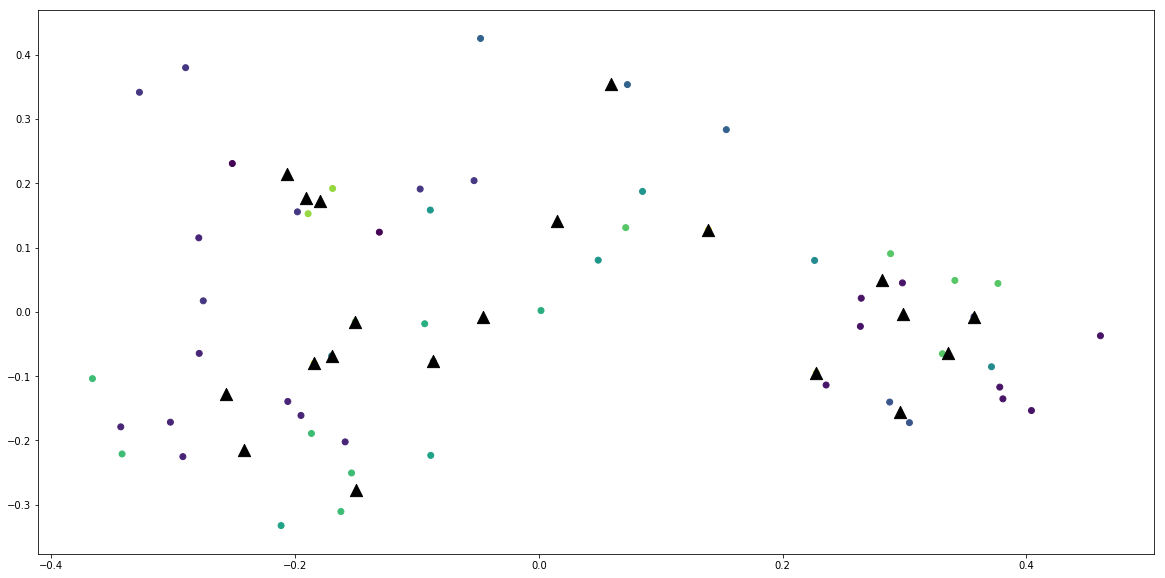

In [28]:

plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [29]:
ldamodel[corpus[0]]

[(15, 0.99394906)]

In [30]:
ldamodel.print_topic(11)

'0.035*"congress" + 0.026*"territory" + 0.022*"slavery" + 0.022*"importance" + 0.018*"form" + 0.018*"event" + 0.018*"spirit" + 0.018*"progress" + 0.018*"trade" + 0.018*"mean"'

In [31]:
hdpmodel = gensim.models.HdpModel(corpus, id2word=dictionary)

In [32]:
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=               Freq  cluster  topics         x         y
topic                                                   
0      1.216707e+01        1       1  0.057794  0.007072
1      7.164668e+00        1       2  0.021806 -0.008758
2      6.954998e+00        1       3  0.060508  0.002615
4      6.578804e+00        1       4 -0.005244  0.016269
3      6.307564e+00        1       5  0.047746  0.005878
8      5.833851e+00        1       6  0.034592  0.018924
10     5.350825e+00        1       7  0.020312  0.017616
5      4.049117e+00        1       8  0.053913 -0.000915
6      4.019306e+00        1       9  0.024074 -0.008060
11     3.999239e+00        1      10  0.014591 -0.018816
13     3.908682e+00        1      11  0.009989  0.017759
7      3.740131e+00        1      12  0.027469  0.016329
15     2.951075e+00        1      13  0.025937 -0.013526
16     2.694870e+00        1      14  0.039640 -0.017700
14     2.318492e+00        1      15  0.042692  0.019915
22     2.170192e+00        1      16  0.014664 -0.015991
19     2.118477e+00        1      17  0.011601  0.012723
12     1.931638e+00        1      18  0.004364 -0.012459
21     1.900343e+00        1      19  0.010406 -0.013391
9      1.844987e+00        1      20  0.001710  0.007081
23     1.782362e+00        1      21  0.026590  0.021919
25     1.431117e+00        1      22  0.007190  0.008176
53     1.337330e+00        1      23  0.008303  0.015261
18     1.158625e+00        1      24 -0.037338 -0.033820
50     9.025674e-01        1      25 -0.001715 -0.005336
17     7.937432e-01        1      26 -0.001182  0.009073
33     7.935065e-01        1      27 -0.001814 -0.004588
24     5.810384e-01        1      28 -0.004455  0.028520
64     5.627194e-01        1      29 -0.018294 -0.011678
81     4.797413e-01        1      30  0.013690 -0.021637
...             ...      ...     ...       ...       ...
118    2.319999e-20        1     121 -0.006873 -0.006906
119    1.323361e-20        1     122  0.041449 -0.000844
120    7.574009e-21        1     123 -0.029311  0.013087
121    4.318860e-21        1     124 -0.022618 -0.049339
122    2.462915e-21        1     125 -0.023327 -0.013283
123    1.404779e-21        1     126  0.025644 -0.024036
124    8.008017e-22        1     127 -0.001472  0.006860
125    4.573182e-22        1     128 -0.004034  0.000701
126    2.598491e-22        1     129 -0.001440  0.008856
127    1.477791e-22        1     130 -0.002266  0.021293
128    8.404133e-23        1     131 -0.010968  0.019326
129    4.811339e-23        1     132  0.003524  0.019712
130    2.716339e-23        1     133 -0.011340  0.012629
131    1.533144e-23        1     134 -0.024819  0.021104
132    8.675893e-24        1     135 -0.001147 -0.001373
133    4.929822e-24        1     136  0.000830 -0.021691
134    2.770215e-24        1     137 -0.004584  0.019804
136    8.962898e-25        1     138  0.024043 -0.015188
137    4.941459e-25        1     139 -0.038991  0.009650
138    2.800067e-25        1     140  0.019944 -0.027599
139    1.552885e-25        1     141 -0.012675 -0.050236
140    8.603601e-26        1     142 -0.013150  0.028495
141    4.776297e-26        1     143  0.004350  0.007416
142    2.657325e-26        1     144 -0.004785 -0.020576
143    1.477060e-26        1     145 -0.011499  0.007480
144    8.195038e-27        1     146  0.006188 -0.013858
145    4.538790e-27        1     147 -0.007739 -0.019240
146    2.504084e-27        1     148 -0.017545  0.006369
147    1.384057e-27        1     149 -0.041763 -0.010776
148    7.628924e-28        1     150 -0.033057 -0.010678

[150 rows x 5 columns], topic_info=      Category          Freq            Term      Total  loglift  logprob
term                                                                     
20     Default  3.600000e+01            hand  36.000000  30.0000  30.0000
74     Default  4.200000e+01         freedom  42.000000  29.0000  29.0000
239    Default  2.900000e+01           labor  

In [33]:
hdpmodel[corpus[23]]

[(16, 0.99295471465848462)]

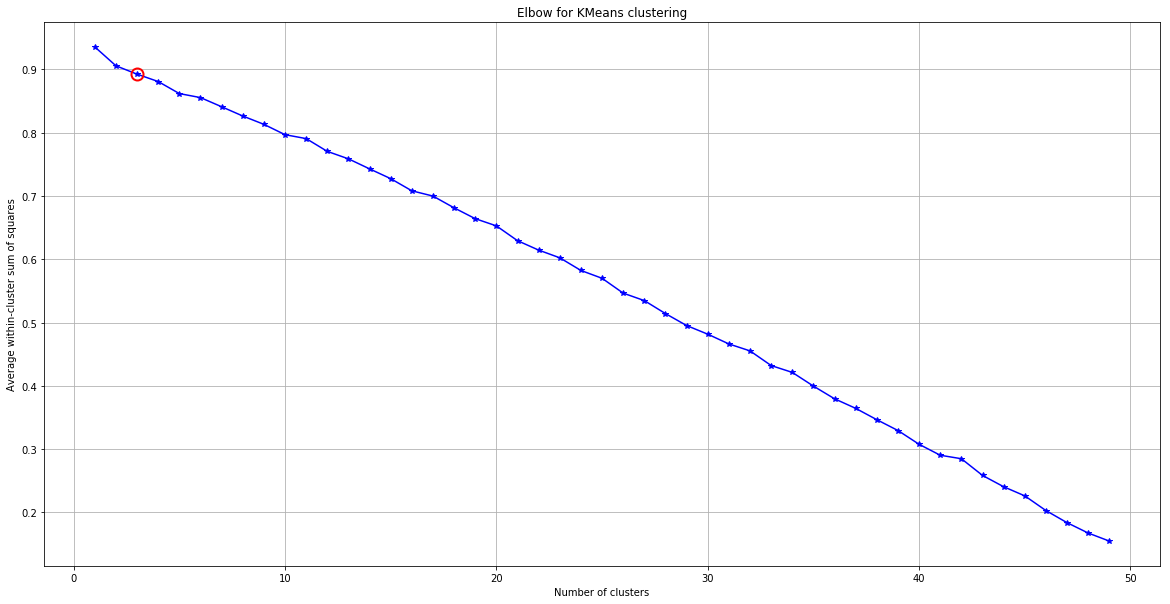

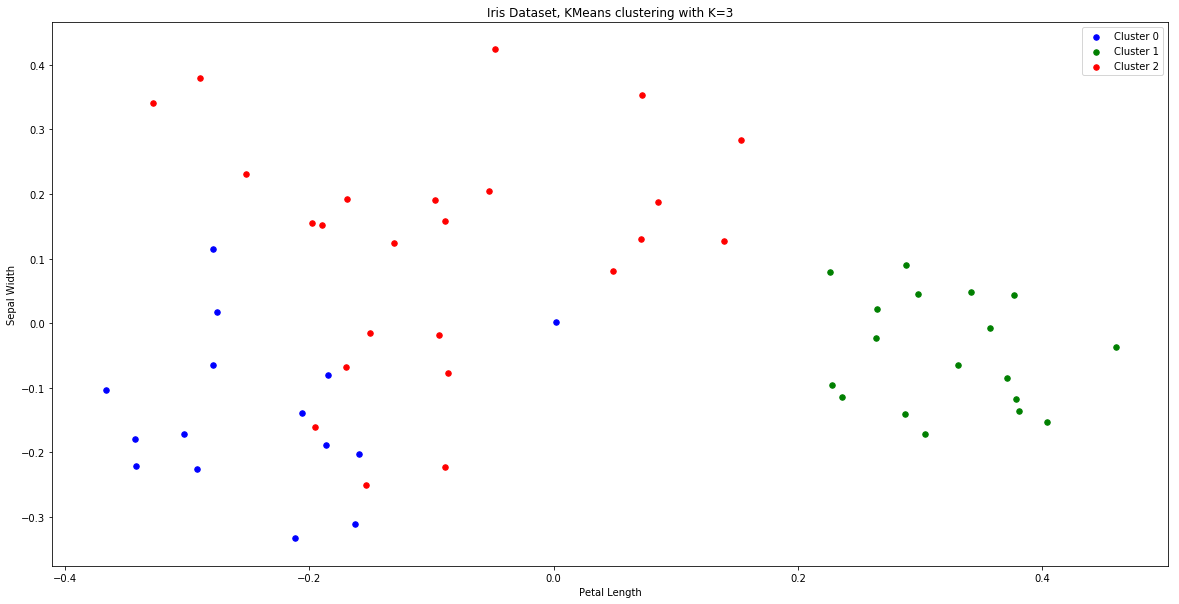

In [42]:
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# load the iris dataset

X = wordvector_fit.todense()


##### cluster data into K=1..10 clusters #####
K = range(1,50)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
#avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.cluster.vq.vq
#Z = [vq(X,cent) for cent in centroids]
#avgWithinSS = [sum(dist)/X.shape[0] for (cIdx,dist) in Z]

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(datapoint[ind,0],datapoint[ind,1], s=30, c=clr[i], label='Cluster %d'%i)
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset, KMeans clustering with K=%d' % K[kIdx])
plt.legend()

plt.show()